# Checking Outcome Distributions Against Model Predictions in Stochastic Reserving (using example of Residual Dependence in Stochastic Chain Ladder Models)

The notebook was prepared by 
- Ben Zickel, Physicist & Engineer and PredicTri CoFounder,
- Yulia Yulish Nechay, Fellow Actuary and PredicTri CoFounder.

# Background

This notebook demonstrates how to check whether the distribution of actual outcomes matches the predictions of your stochastic reserving model.
We illustrate the approach using a specific example: what happens when the standard stochastic chain ladder model assumes that residuals are independent, but in reality they are dependent.

This notebook helps you:
- Check the accuracy of your model’s predictions by comparing actual back-tested outcomes to the predicted percentile distribution.

- Identify signs of model mis-specification (such as residual dependence).

- Understand how assumption violations (e.g. residual independence) can distort predictions, particularly underestimating the likelihood of extreme outcomes. 

While the example here focuses on residual dependence, the same method can test any kind of misalignment between predicted and actual outcome distributions.

# Key Concepts

Residuals are the differences between what the model predicts and what actually happens, at each development step. In stochastic models that assume log-normality, for each age $i$:

$$residual_i = log(actual_i) - log(predicted_i)$$

Residuals help us understand how well our model fits the data.

We also define the increments of residuals as:

$$increment_i = residual_i - residual_{i-1}$$

In stochastic chain ladder models, we usually assume that increments of residuals over age are:

- independent: one period’s incremental error doesn’t influence the next,
- normally distributed: the errors follow a bell-shaped curve.


# Why Independence Matters

If increments of residuals are dependent (for example, if a large residual tends to be followed by another large residual), then the variability of ultimate losses may be higher or lower than our model predicts.
This can make our confidence intervals and percentiles inaccurate — and lead to underestimating the risk of extreme outcomes.

# Model

The model used is an auto regressive time series model of the first order, a.k.a. AR(1) model. The residuals $R_i$ (shorhand for $residual_i$) are described by the equation

$$R_{i+1} = \alpha R_i + \epsilon_i$$

where $\epsilon_i$ are normally distributed and independent, as we are modeling the log of the losses, and $\alpha$ is an unknown factor of the model.

$\alpha$ determines how strong the dependence is:

- If $\alpha$ = 1, residuals are independent.
- If $\alpha$ > 1, good or bad outcomes tend to persist.
- If $\alpha$ < 1, good or bad outcomes tend to reverse.

The increments of the residuals (remember these are the changes in the residuals from one period to the next) are:

$$\Delta{R_i} = R_i - R_{i-1} = (\alpha - 1)R_{i-1} + \epsilon_{i-1}$$

which means that increments of residuals are uncorrelated with previous increments of residuals only when $\alpha=1$. 

Another important feature of this model is that for $|\alpha|>1$ we have an ever increasing variance of the residuals such that

$$\mathrm{Var}[R_{i+1}] > \mathrm{Var}[R_i]$$

while for $|\alpha|<1$ there is a possibility for variance reduction of subsequent residuals.

# Results interpretation

In order to check the percentiles of actual outcomes, compared to the predicted distribution assuming independent increments of residuals, we plot a histogram of these percentiles.
If the model assumptions are correct, these percentiles should follow a uniform distribution (flat histogram).

If the histogram is U-shaped or uneven, it suggests the model assumptions are wrong:
- U-shaped (more observations in the tails than in the middle): actual outcomes are more extreme (both high and low) than predicted — your model underestimates variability. This can happen if increments of residuals are dependent or there’s unaccounted systemic risk.
- Peaked in the middle (fewer extremes than expected): Actual outcomes are too concentrated near the median — your model overestimates variability.
- Skewed (one tail heavier than the other): The model systematically under- or overestimates the mean, or has asymmetry in uncertainty that isn’t reflected in predictions.

# Simulation

We show three scenarios:
- Positive dependence ($\alpha=1.5$): the variance of residuals keeps growing over time, i.e. “good” results become “better” on average, “bad” results become “worse” on average; higher chance of extremes.
- No dependence ($\alpha=1$): outcomes as expected, which is the usual assumption in the stochastic chain ladder.
- Negative dependence ($\alpha=0.5$):  the variance of residuals decreases over time, “good” results become “worse” on average, “bad” results become “better” on average.



In [1]:
from scipy.stats import norm
from matplotlib.pyplot import hist, xlabel, ylabel, title, figure

def plot_ultimate_percentiles(factor, N=10000):
    # Sample the first residual
    first_age_residual = norm().rvs(N)
    # Derive the mean of the ultimate residual from the first residual
    mean_ultimate_residual = factor * first_age_residual
    # Generate the development uncertainty from the first residual to the ultimate residual
    first_age_to_ultimate_uncertainty = norm().rvs(N)
    # Calculate the ultimate residual
    ultimate_residual = mean_ultimate_residual + first_age_to_ultimate_uncertainty
    # Calculate the percentile of the ultimate residual based on a model with a factor of one
    ultimate_percentile = norm().cdf(ultimate_residual - first_age_residual)
    hist(ultimate_percentile)
    xlabel('Percentile')
    ylabel('Count')
    title(f'Percentile Histogram for Factor={factor}')


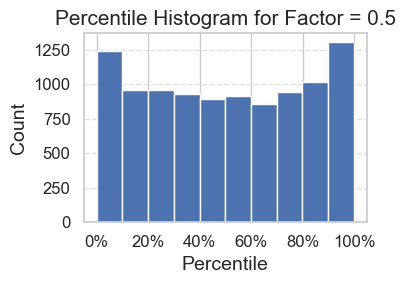

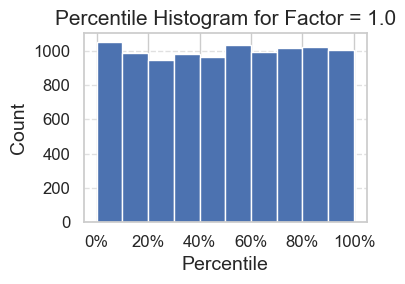

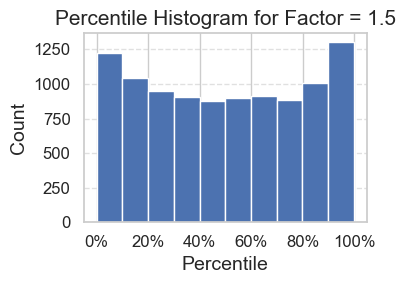

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

sns.set(style="whitegrid")

for factor in [0.5, 1.0, 1.5]:
    plt.figure(figsize=(4, 3))
    plot_ultimate_percentiles(factor=factor)

    plt.title(f"Percentile Histogram for Factor = {factor}", fontsize=15)
    plt.xlabel("Percentile", fontsize=14)
    plt.ylabel("Count", fontsize=14)

    # Format x-axis as percentages
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Conclusions

The standard stochastic chain ladder model assumes that increments of residuals are independent (α=1). In this case we see that the distribution is uniform as expected.

 But as these results show, if in reality the increments of residuals have dependence, the predicted percentiles of outcomes can underestimate the likelihood of extreme events as uncertainty is not captured. Both for the first and last case the histograms below show that extreme events happen with higher probability than that predicted by the model.

This suggests that part of what is sometimes attributed to "systemic risk" may actually stem from incorrectly assuming independence in the increments of the residuals.

Although modeling dependent increments of residuals is more complex, it may help explain patterns seen in practice. 

 # Check Your Own Data

You can use this notebook to check if your own reserving model correctly accounts for residual dependence or any other factors that cause the outcome distribution to deviate from predictions.

# Why Do This?
If your model assumes independent increments of residuals but they’re not, your prediction intervals may be too narrow and your risk underestimated.

More broadly, even if residual dependence is not the issue, any misalignment between the model’s assumptions and reality: such as structural bias, incorrect variance assumptions, or unaccounted systemic risk can distort the predicted outcome distribution.

### 1.Prepare Your Data
To run this check, you need a following dataset:

|Model / Period | Ultimate   | Q=0.1%   | Q=0.2%   | …   | Q=99.9%   |
|--------|------------|----------|----------|-----|----------|
| 2004   | 257,115    | 228,185  | 230,219  | …   | 287,206  |
| 2005   | 268,865    | 224,704  | 226,318  | …   | 295,570  |
| 2006   | 265,714    | …        | …        | …   | …        |

- Observed outcomes: the actual ultimate losses for each model or  year.
- Predictive distributions: the simulated or bootstrapped percentiles your model predicted for same models / periods.

Note: If you use multiple periods from the same portfolio, they may be correlated, which can distort the distribution and make it appear less uniform than it truly is.
To reduce this effect (if you have enough data), you can sample fewer points: for example, by taking every 3rd or 4th period instead of all periods.

Ideally, validate your model on a set of independent portfolios to accurately assess its predictive performance.

### 2.Upload Your Data

In [3]:
import pandas as pd

# Replace with the path to your Excel file
df = pd.read_excel(r"Data/Input_for_Test_Distribution_Residuals_Model_Errors_Notebook.xlsx", sheet_name="data")

# Preview the first few rows
df.head()

,Period,Exposure,Ultimate,Q=0.1%,Q=0.2%,Q=0.3%,Q=0.4%,Q=0.5%,Q=0.6%,Q=0.7%,...,Q=99.0%,Q=99.1%,Q=99.2%,Q=99.3%,Q=99.4%,Q=99.5%,Q=99.6%,Q=99.7%,Q=99.8%,Q=99.9%
0,2004,248825,257115.0,228185.239931,230219.033743,231429.476484,232351.105565,233071.567034,233625.106777,234105.886403,...,279223.533863,279716.293041,280149.760916,280784.625903,281383.596284,282011.002060,282874.373170,283826.111908,285183.072360,287206.726028
1,2005,237844,268865.0,224704.233544,226318.933370,227839.203905,228781.727317,229696.447374,230301.085043,230787.923540,...,285179.310083,285654.248875,286275.895677,286853.274247,287529.223782,288208.386969,289276.630242,290516.176332,292442.441567,295570.328073
2,2006,226807,265714.0,225201.861010,226997.703884,228414.429759,229581.041175,230346.451496,231090.577370,231705.091489,...,292877.368988,293489.209872,294108.135754,294844.651197,295730.405052,296689.315408,297785.528341,299208.566412,301226.631529,304065.180383
3,2007,229541,244151.0,214819.983222,216904.007644,218332.125576,219449.006148,220367.420180,221152.924552,221764.685106,...,284370.211006,285040.997243,285646.270361,286292.252103,287263.084021,288414.597672,289596.307590,291120.810619,293408.263195,296817.867792
4,2008,214218,275052.0,231035.262910,233908.015318,235427.999384,236929.466098,237863.974436,238765.740772,239527.816455,...,312850.684665,313568.335682,314347.949352,315028.887242,316240.073404,317265.394029,318702.534739,320466.979800,323218.760433,327779.270867


### 3.Calculate Percentiles

In [4]:

import numpy as np

# Get a list of predictive quantile columns
quantile_cols = [col for col in df.columns if col.startswith("Q=")]
predictions_quantiles = np.array([float(col[2:-1]) / 100 for col in quantile_cols])

def calculate_percentile(actual, predictions, predictions_quantiles):
    return predictions_quantiles[predictions <= actual].max()

# Apply row by row
df['percentile'] = df.apply(
    lambda row: calculate_percentile(
        row['Ultimate'],
        row[quantile_cols].values,
        predictions_quantiles
    ),
    axis=1
)

# Preview
df[['Period', 'Ultimate', 'percentile']].head(5)

,Period,Ultimate,percentile
0,2004,257115.0,0.53
1,2005,268865.0,0.83
2,2006,265714.0,0.63
3,2007,244151.0,0.27
4,2008,275052.0,0.49


### 4. Plot the Histogram
We plot the histogram of percentiles.  
The number of bins is chosen using the square-root rule:  
`bins = int(sqrt(number of periods))`, but at least 5 bins

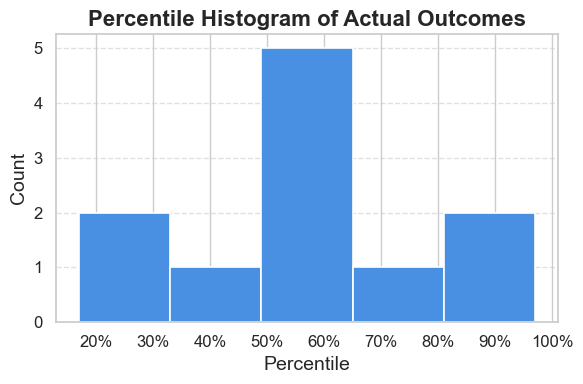

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

# Calculate number of bins
n_periods = len(df)
n_bins = max(5, int(np.sqrt(n_periods)))

plt.figure(figsize=(6, 4))
plt.hist(
    df['percentile'], 
    bins=n_bins, 
    color="#4a90e2", 
    edgecolor='white', 
    linewidth=1.2
)

plt.title("Percentile Histogram of Actual Outcomes", fontsize=16, weight='bold')
plt.xlabel("Percentile", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Format x-axis as percentages
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Improve tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Next Steps if You Detect Dependence
If your analysis suggests that incrmeents of residuals are not independent, you should reconsider relying on models that assume independence. Instead, you can:

- Stop using methods that assume independent increments of residuals — the standard stochastic chain ladder may no longer be appropriate.
- Consider alternative models that incorporate dependence, such as autoregressive (AR) models or time-series based approaches.
- Adjust prediction intervals to reflect increased uncertainty, acknowledging that the standard model underestimates extreme outcomes.
- Discuss implications with stakeholders, as your findings may affect reserving levels and capital requirements.